# Imports

In [204]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import tsaugmentation as tsag

sns.set()
plt.rcParams.update({'font.size': 22})

# Helper functions

In [205]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [206]:
def parse_file_name(file, dataset):
    flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
    idx_dataset_name = find(flatten_file_name, dataset)[0]
    sample = flatten_file_name[idx_dataset_name+1:-1][-1]
    version = flatten_file_name[idx_dataset_name+1:-1][-2]
    transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
    return sample, version, transformation

def compute_aggreated_results_dict(algorithm, dataset, path='../results_probabilistic', err_metric='mase'):
    results_dict={}
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            sample, version, transformation = parse_file_name(file, dataset)
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}
                
            results_dict_temp = copy.deepcopy(results_dict)
            results_dict_temp[transformation][version][sample] = pickle.load(handle)

            results_dict[transformation][version][sample][err_metric] = {}

            # We are getting the results for each group as lists and we want to store it 
            # as objects such as {'mase': {bottom_ind_1: value}, {bottom_ind_2: value}}
            for (k,v_) in results_dict_temp[transformation][version][sample][err_metric].items():
                # if it is the original versions we only want to get the individual results
                try: 
                    for i in range(len(v_)):
                        results_dict[transformation][version][sample][err_metric][f'{k}_{i}'] = v_[i]
                except TypeError:
                    # the group has individual results
                    pass
        handle.close()
    return results_dict

In [238]:
def compute_aggregated_results_df(results_dict):
    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all
    
    df = pd.DataFrame.from_dict({(i, j, k, l): results_dict[i][j][k][l]
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()
                           for l in results_dict[i][j][k].keys()}, orient='index')
    df = df.reset_index()
    df.rename(columns={'level_0':'transformation',
                       'level_1':'version',
                       'level_2':'sample',
                       'level_3':'error',}, inplace=True)
    df = df.melt(id_vars=['transformation', 'version', 'sample', 'error'],
           var_name = 'group',
           value_name = 'value')
    df = df.groupby(['group', 'version', 'sample', 'error']).mean().reset_index()
    df['group'] = df['group'].str.split('_').str[0]
    df['group'] = df['group'].str.lower()
    df.dropna(inplace=True)
    
    return df

# Calculation of CRPS - example for a single series

In [208]:
data = tsag.preprocessing.PreprocessDatasets('prison').apply_preprocess()

In [210]:
true = data['predict']['data'].reshape((32, 48)).T

### GPF

In [355]:
dataset = 'prison'
algorithm='gpf'
for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path]:
    with open(f'{path}/{file}', 'rb') as handle:
        e = pickle.load(handle)
        handle.close()

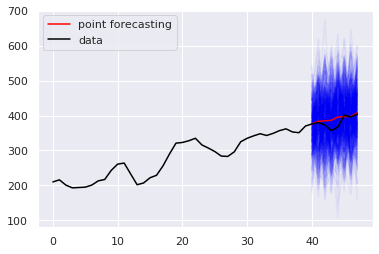

In [356]:
series = 29
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [357]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

18.974087812335156

### MinT

In [288]:
dataset = 'prison'
algorithm='mint'
for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path]:
    with open(f'{path}/{file}', 'rb') as handle:
        e = pickle.load(handle)
        handle.close()

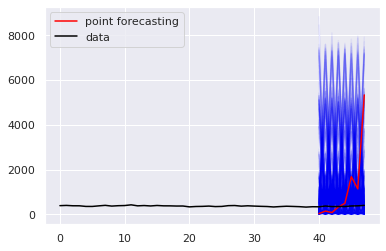

In [289]:
series = 16
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data');
plt.legend();

In [271]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

230.95682941573097

### DeepAR

In [351]:
dataset = 'prison'
algorithm='deepar'
for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path]:
    with open(f'{path}/{file}', 'rb') as handle:
        e = pickle.load(handle)
        handle.close()

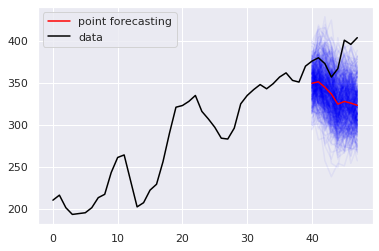

In [354]:
series = 29
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [353]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

48.3536535

# Calculating aggregate results for all algorithms

In [239]:
datasets = ['prison']
df_orig_list = []
for d in datasets:
    dict_gpf = compute_aggreated_results_dict(algorithm='gpf', dataset=d, err_metric='CRPS')
    df_gpf = compute_aggregated_results_df(dict_gpf)
    dict_mint = compute_aggreated_results_dict(algorithm='mint', dataset=d, err_metric='CRPS')
    df_mint = compute_aggregated_results_df(dict_mint)
    dict_deepar = compute_aggreated_results_dict(algorithm='deepar', dataset=d, err_metric='CRPS')
    df_deepar = compute_aggregated_results_df(dict_deepar)
    df_gpf['algorithm']='gpf'
    df_mint['algorithm']='mint'
    df_deepar['algorithm']='deepar'
    df = pd.concat([df_gpf, df_mint, df_deepar])
    df_orig = df[(df['version']=='orig')&(df['error']=='CRPS')].reset_index().drop(['index'], axis=1)

    # sort values by algorithm to plot gpf -> mint -> deepar
    sorter = ['gpf', 'mint', 'deepar']
    df_orig = df_orig.sort_values(by='group')
    df_orig.algorithm = df_orig.algorithm.astype("category")
    df_orig.algorithm.cat.set_categories(sorter, inplace=True)
    df_orig_list.append(df_orig)

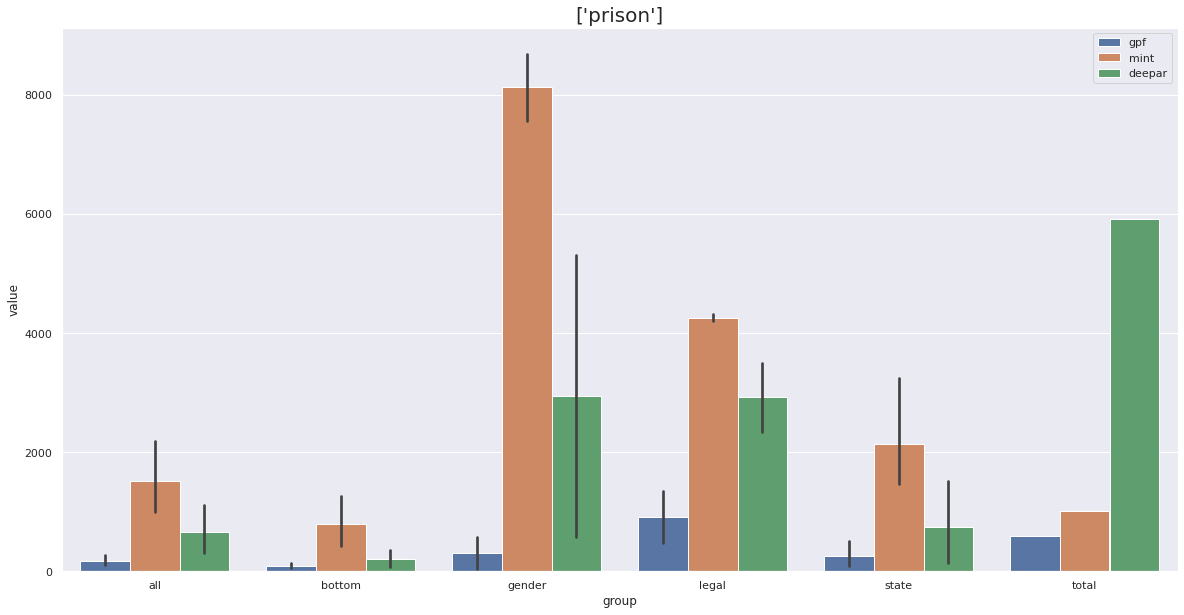

In [240]:
_, ax = plt.subplots(len(datasets), 1, figsize=(20, 10*len(datasets)))
fg = sns.barplot(x='group', 
                 y='value',
                 hue='algorithm',
                 data=df_orig_list[i],
                 ax=ax)
ax.set_title(datasets, fontsize=20)
plt.legend()
plt.show()

In [234]:
_, ax = plt.subplots(len(datasets), 1, figsize=(20, 10*len(datasets)))
ax = ax.ravel()
for i in range(len(datasets)):
    fg = sns.barplot(x='group', 
                     y='value',
                     hue='algorithm',
                     data=df_orig_list[i],
                     ax=ax[i])
    ax[i].set_title(datasets[i], fontsize=20)
plt.legend()
plt.show()